# **<center>Imports</center>**

In [290]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta, Lion, Nadam, Ftrl, AdamW
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from skimage.io import imsave
import cv2

#Utilities
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# **<center>Data Collection</center>**

In [135]:
train_data_path = "photos/train/"
test_data_path = "photos/test/"
val_data_path = "photos/val/"

In [136]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(train_data_path, target_size=(256,256), batch_size=50, class_mode=None)

Found 2426 images belonging to 1 classes.


In [137]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(test_data_path, target_size=(256, 256), batch_size=50, class_mode=None)

Found 2426 images belonging to 1 classes.


In [138]:
val_gen = ImageDataGenerator(rescale=1./255)
val = val_gen.flow_from_directory(val_data_path, target_size=(256, 256), batch_size=50, class_mode=None)

Found 168 images belonging to 1 classes.


In [139]:
def prepareInputData(path, h, w):
    X=[]
    y=[]
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (w, h)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X.append(img_l)
            y.append(img_ab)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [140]:
X_train,y_train = prepareInputData(train_data_path + "train_data/", 256, 256)
X_test, y_test = prepareInputData(test_data_path + "test_data/", 256, 256)
X_val, y_val = prepareInputData(val_data_path + "val_data/", 256, 256)

Premature end of JPEG file
Premature end of JPEG file


In [141]:
X_train[0]

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]], dtype=float32)

In [533]:
np.unique(y_train[6])

array([0.], dtype=float32)

# **<center>Making the Model</center>**

In [550]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [581]:
def createModelTwo(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)


    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [582]:
networkInput = Input(shape=(256, 256,1))
networkOutput = createModelTwo(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

In [483]:
def custom_loss(y_true, y_pred):
    # Split the predicted and ground truth tensors into a and b channels
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    # Compute the Euclidean distance between a and b channels 4
    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    
    # Compute hue and saturation from a and b channels of predicted image
    hue_true = tf.math.atan2(b_true, a_true) #-pi to pi
    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true)) 
    hue_pred = tf.math.atan2(b_pred, a_pred)
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    
    # Define the weighting factor for emphasizing saturation over hue
    saturation_weight = 3.0
    
    # Compute the weighted hue-saturation loss
    hue_saturation_loss = tf.square(hue_pred - hue_true) + saturation_weight * tf.square(saturation_pred - saturation_true)
    
    # Combine the color loss and hue-saturation loss
    total_loss = tf.add(color_loss,hue_saturation_loss)
    
    # Return the mean loss over the batch
    return tf.reduce_mean(tf.sqrt(hue_saturation_loss))


In [572]:
def hue_bin_loss(y_true, y_pred):
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, tf.abs(y_pred - y_true)/8)

    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    sl = tf.abs(saturation_true - saturation_pred)

#    color_loss = 0.1*tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
#    total_loss = tf.add(color_loss, sl + hl)

    return tf.reduce_mean(sl + hl)  # Use reduce_mean to ensure a scalar loss value


In [282]:
def custom_hue_loss(y_true, y_pred):
    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, 0.1 * tf.abs(y_pred - y_true))

    return hl


In [583]:
LEARNING_RATE = 0.001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss=hue_bin_loss)
model.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_418 (Conv2D)         (None, 256, 256, 64)      640       
                                                                 
 leaky_re_lu_372 (LeakyReLU  (None, 256, 256, 64)      0         
 )                                                               
                                                                 
 batch_normalization_372 (B  (None, 256, 256, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_419 (Conv2D)         (None, 256, 256, 2)       1154      
                                                                 
Total params: 2050 (8.01 KB)
Trainable params: 1922 (7.51 

In [584]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

history = model.fit(GenerateInputs(X_train,y_train),epochs=50,verbose=1,steps_per_epoch=45, shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=45)

Epoch 1/50


2023-12-28 20:02:24.218647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/45 [==========================>...] - ETA: 0s - loss: 0.0719

2023-12-28 20:02:25.198605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 1s 23ms/step - loss: 0.0694 - val_loss: 1.5316
Epoch 2/50
45/45 [==============================] - 1s 17ms/step - loss: 0.1010 - val_loss: 1.2452
Epoch 3/50
45/45 [==============================] - 1s 16ms/step - loss: 0.0893 - val_loss: 1.4558
Epoch 4/50
45/45 [==============================] - 1s 15ms/step - loss: 0.0568 - val_loss: 1.0092
Epoch 5/50
45/45 [==============================] - 1s 15ms/step - loss: 0.0883 - val_loss: 1.3801
Epoch 6/50
45/45 [==============================] - 1s 15ms/step - loss: 0.0761 - val_loss: 1.0661
Epoch 7/50
45/45 [==============================] - 1s 15ms/step - loss: 0.0474 - val_loss: 1.1110
Epoch 8/50
45/45 [==============================] - 1s 16ms/step - loss: 0.1624 - val_loss: 1.1534
Epoch 9/50
45/45 [==============================] - 1s 15ms/step - loss: 0.1065 - val_loss: 1.4988
Epoch 10/50
45/45 [==============================] - 1s 15ms/step - loss: 0.0627 - val_loss: 1.2815
Epoch 11/50
45/45 [=

In [431]:
data = {
 #   "acc": list(history.history["acc"]),
#    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [299]:
chart = Line("Model Results")
chart.set_options(
    labels=list(range(50)),
    x_label="Epoch",
    y_label="Percent",
)


#chart.add_series("acc", data["acc"])
#chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
#chart.render_notebook()
chart.render_notebook()

# **<center>Testing the Model</center>**

In [556]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [585]:
TestImagePath="photos/val/val_data/YLRmLiTMgSY.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = model.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 57ms/step
Prediction made
reshaped


2023-12-28 20:03:10.622449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [33]:
Prediction.shape

(256, 256, 2)

In [576]:
np.unique(Prediction[:,:,1])

array([-127.990135, -127.9689  , -127.95771 , ...,  127.79094 ,
        127.846   ,  127.84872 ], dtype=float32)

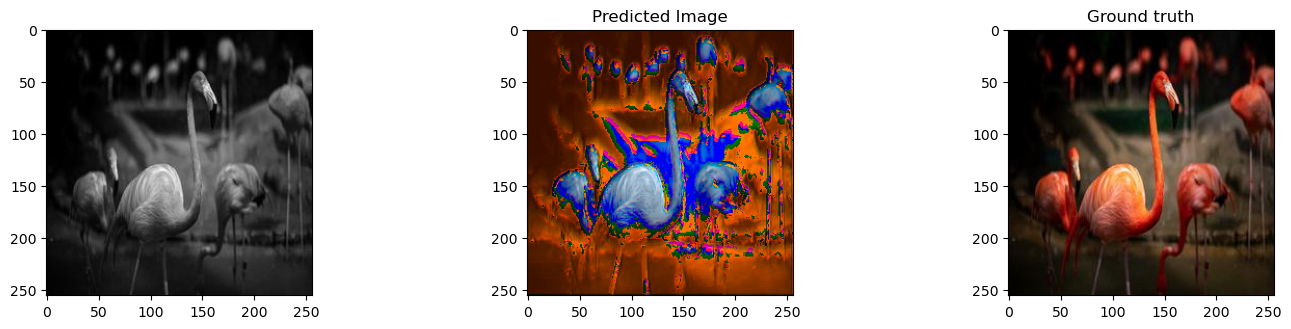

In [586]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img_1, cv2.COLOR_RGB2Lab)
img_[:,:,1] = Prediction[:,:,0]
img_[:,:,2] = Prediction[:,:,1]
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

1/1 [==============================] - 0s 12ms/step
(1, 256, 256, 1)
(1, 256, 256, 2)


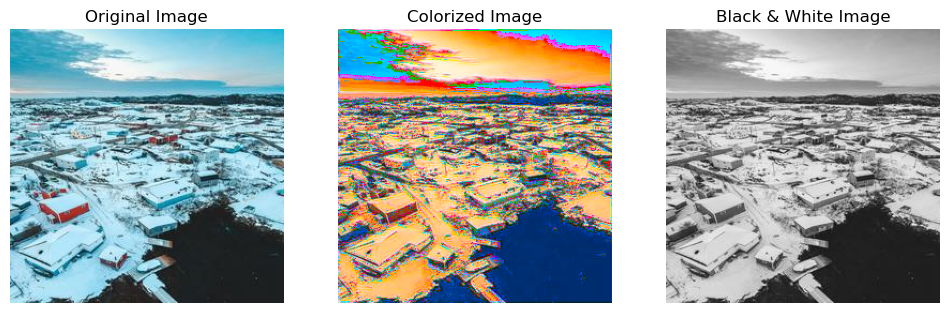

In [587]:
# Load a sample test image
TestImagePath = "photos/val/val_data/ztBHq2Os5k0.jpg"
img = cv2.imread(TestImagePath)

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()


In [580]:
len(np.unique(Prediction[:,:,0]))

65057

1/1 [==============================] - 0s 12ms/step
(1, 256, 256, 1)
(1, 256, 256, 2)


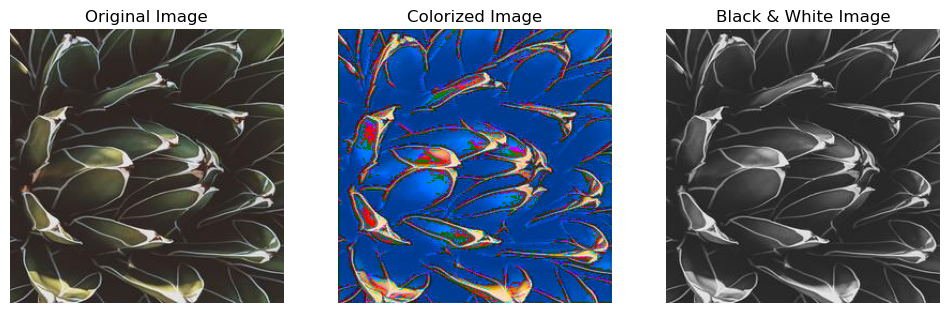

In [593]:
# Load a sample test image
TestImagePath = "photos/val/val_data/YIp0r1i3KJ0.jpg"
img = cv2.imread(TestImagePath)

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()
